# Chapter 8: Cosine Function Fitting with a Quantum Neural Network (QNN)

The variational circuit used is the continuous-variable quantum neural
network model described in:

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`


In [14]:
# Import PennyLane, the wrapped version of NumPy provided by PennyLane,and an optimizer.
import pennylane as qml
from pennylane import numpy as np
from pennylane.optimize import AdamOptimizer

In [15]:
import matplotlib.pyplot as plt
import numpy as np
import pylab
import pickle

## Data Creation:  Noisy Cosine Function for Sampling

In [16]:
Xlim = 5
noise = np.random.normal(0,0.1,100) # generate noise to add to the function values (Y-values)
# define functions
X = np.arange(-Xlim, Xlim, 0.1)
Y = np.cos(X)+noise

This will generate two lists 'X' and 'Y' with our X-axis and Y-axis data. The Y-axis data will be copied into a file called "cosdata.md" for future use.

In [17]:
# write the data out to a file
cosdata = open('cosdata.md', 'wb')
pickle.dump(Y, cosdata)
cosdata.close()

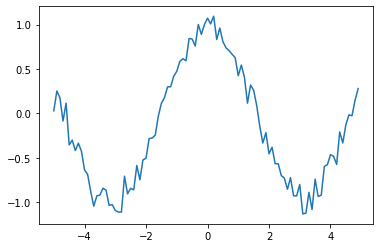

In [18]:
plt.plot(X[0:200], Y[0:200])

In [19]:
dev = qml.device("strawberryfields.fock", wires=1, cutoff_dim=10)

### Quantum node
For a single quantum mode, each layer of the variational circuit is defined as:

In [20]:
def layer(v):
    # Matrix multiplication of input layer
    qml.Rotation(v[0], wires=0)
    qml.Squeezing(v[1], 0.0, wires=0)
    qml.Rotation(v[2], wires=0)

    # Bias
    qml.Displacement(v[3], 0.0, wires=0)

    # Element-wise nonlinear transformation
    qml.Kerr(v[4], wires=0)

The variational circuit in the quantum node first encodes the input into
the displacement of the mode, and then executes the layers. The output
is the expectation of the x-quadrature.

In [21]:
@qml.qnode(dev)
def quantum_neural_net(var, x=None):
    # Encode input x into quantum state
    qml.Displacement(x, 0.0, wires=0)

    # "layer" subcircuits
    for v in var:
        layer(v)

    return qml.expval(qml.X(0))

### Objective
As an objective we take the square loss between target labels and model
predictions.

In [22]:
def square_loss(labels, predictions):
    loss = 0
    for l, p in zip(labels, predictions):
        loss = loss + (l - p) ** 2

    loss = loss / len(labels)
    return loss

In the cost function, we compute the outputs from the variational
circuit. Function fitting is a regression problem, and we interpret the
expectations from the quantum node as predictions (i.e., without
applying postprocessing such as thresholding).


In [23]:
def cost(var, features, labels):
    preds = [quantum_neural_net(var, x=x) for x in features]
    return square_loss(labels, preds)

### Optimization
We load noisy data samples of a sine function and before training a model, we examine the data.

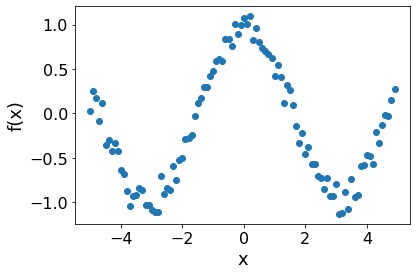

In [24]:
plt.figure()
plt.scatter(X, Y)
plt.xlabel("x", fontsize=18)
plt.ylabel("f(x)", fontsize=18)
plt.tick_params(axis="both", which="major", labelsize=16)
plt.tick_params(axis="both", which="minor", labelsize=16)
plt.show()

The network’s weights (called ``var`` here) are initialized with values
sampled from a normal distribution. We use 4 layers; performance has
been found to plateau at around 6 layers.

In [25]:
np.random.seed(0)
num_layers = 4
var_init = 0.05 * np.random.randn(num_layers, 5)
print(var_init)

[[ 0.08820262  0.02000786  0.0489369   0.11204466  0.0933779 ]
 [-0.04886389  0.04750442 -0.00756786 -0.00516094  0.02052993]
 [ 0.00720218  0.07271368  0.03805189  0.00608375  0.02219316]
 [ 0.01668372  0.07470395 -0.01025791  0.01565339 -0.04270479]]


In [30]:
opt = AdamOptimizer(0.01, beta1=0.9, beta2=0.999)

var = var_init
for it in range(50):
    var = opt.step(lambda v: cost(v, X, Y), var)
    print("Iter: {:5d} | Cost: {:0.7f} ".format(it + 1, cost(var, X, Y)))

Iter:     1 | Cost: 1.1368855 
Iter:     2 | Cost: 0.9848804 
Iter:     3 | Cost: 0.9151763 
Iter:     4 | Cost: 0.8904604 
Iter:     5 | Cost: 0.8909280 
Iter:     6 | Cost: 0.9044083 
Iter:     7 | Cost: 0.9230133 
Iter:     8 | Cost: 0.9416181 
Iter:     9 | Cost: 0.9570034 
Iter:    10 | Cost: 0.9672977 
Iter:    11 | Cost: 0.9715885 
Iter:    12 | Cost: 0.9696429 
Iter:    13 | Cost: 0.9617078 
Iter:    14 | Cost: 0.9483643 
Iter:    15 | Cost: 0.9304217 
Iter:    16 | Cost: 0.9088344 
Iter:    17 | Cost: 0.8846331 
Iter:    18 | Cost: 0.8588647 
Iter:    19 | Cost: 0.8325356 
Iter:    20 | Cost: 0.8065613 
Iter:    21 | Cost: 0.7817214 
Iter:    22 | Cost: 0.7586265 
Iter:    23 | Cost: 0.7376979 
Iter:    24 | Cost: 0.7191642 
Iter:    25 | Cost: 0.7030729 
Iter:    26 | Cost: 0.6893169 
Iter:    27 | Cost: 0.6776699 
Iter:    28 | Cost: 0.6678257 
Iter:    29 | Cost: 0.6594372 
Iter:    30 | Cost: 0.6521505 
Iter:    31 | Cost: 0.6456310 
Iter:    32 | Cost: 0.6395822 
Iter:   

Finally, we collect the predictions of the trained model for 50 values
in the range $[0,30]$:

In [37]:
x_pred = np.linspace(-3, 3, 50)
predictions = [quantum_neural_net(var, x=x_) for x_ in x_pred]

and plot the shape of the function that the model has “learned” from
the noisy data (maroon dots).

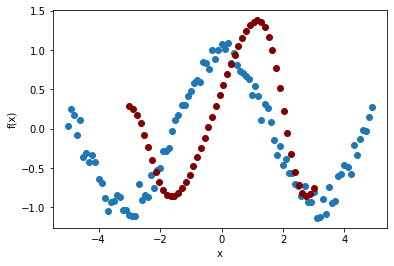

In [44]:
# plot the function
plt.figure()
plt.scatter(X, Y)
plt.scatter(x_pred, predictions, color="maroon")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

The model has learned to smooth the noisy data.

In fact, we can use PennyLane to look at typical functions that the
model produces without being trained at all. The shape of these
functions varies significantly with the variance hyperparameter for the
weight initialization.

Setting this hyperparameter to a small value produces almost linear
functions, since all quantum gates in the variational circuit
approximately perform the identity transformation in that case. Larger
values produce smoothly oscillating functions with a period that depends
on the number of layers used (generically, more the layers, smaller
the period).

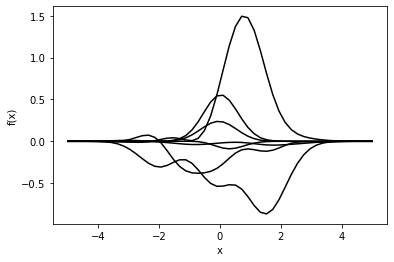

In [34]:
variance = 1.0

plt.figure()
x_pred = np.linspace(-5, 5, 50)
for i in range(7):
    rnd_var = variance * np.random.randn(num_layers, 7)
    predictions = [quantum_neural_net(rnd_var, x=x_) for x_ in x_pred]
    plt.plot(x_pred, predictions, color="black")
plt.xlabel("x")
plt.ylabel("f(x)")
plt.tick_params(axis="both", which="major")
plt.tick_params(axis="both", which="minor")
plt.show()

## References
PennyLane "Function Fitting with a Quantum Neural Network" ```https://pennylane.ai/qml/app/quantum_neural_net.html```

`Killoran et al. (2018) <https://arxiv.org/abs/1806.06871>`

"Adding noise to a signal in python" ```https://stackoverflow.com/questions/14058340/adding-noise-to-a-signal-in-python```